In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# List all physical devices
physical_devices = tf.config.list_physical_devices()
print("Physical devices:", physical_devices)

# Check for GPU specifically
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available.")
else:
    print("GPU is NOT available.")

Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU is NOT available.


In [2]:
# Load your dataset
dataset = pd.read_csv('Dataset.csv')  # Replace with your dataset path
dataset.iloc[:, -1] = dataset.iloc[:, -1] - 1
X = dataset.iloc[:, :-1]  # Features
y = dataset.iloc[:, -1]   # Target

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert labels to categorical
y_categorical = to_categorical(y)

# Shuffle the data
X_scaled, y_categorical = shuffle(X_scaled, y_categorical, random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_categorical, test_size=0.2, random_state=42)

# Number of unique classes in the target variable
num_classes = y_train.shape[1]


# Building the DNN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), name='dense_0'),
    Dense(64, activation='relu', name='dense_1'),
    Dense(32, activation='relu', name='dense_2'),
    Dense(num_classes, activation='softmax')  # Output layer
])

In [3]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,  # minimium amount of change to count as an improvement
    patience=100,  # how many epochs to wait before stopping
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# Set the learning rate
learning_rate = 0.01

# Create the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.9,  # factor by which the learning rate will be reduced
    patience=5,  # number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001,  # lower bound on the learning rate
    verbose=1
)
lr_callback = tf.keras.callbacks.LearningRateScheduler(reduce_lr)

class PrintLR(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []
        
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        elif hasattr(lr, 'eval'):
            lr = lr.eval(session=tf.compat.v1.Session())
        print(f'Epoch {epoch+1}: Learning rate is {lr}.')
    
    def on_epoch_end(self, epoch, logs=None):
        # Retrieve the current learning rate from the optimizer
        current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        # Append the current learning rate to the list
        self.learning_rates.append(current_lr)

lr_tracker = PrintLR()
callbacks = [lr_tracker, early_stopping, reduce_lr]


# Initialize the optimizer with the learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compiling the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [131]:
# Pass the callback to the fit method
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=64,
    callbacks=callbacks  # include it here
)

Epoch 1: Learning rate is 0.009999999776482582.
Epoch 1/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.5754 - accuracy: 0.6907 - val_loss: 0.4053 - val_accuracy: 0.7789
Epoch 2: Learning rate is 0.009999999776482582.
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4118 - accuracy: 0.7828 - val_loss: 0.4593 - val_accuracy: 0.7638
Epoch 3: Learning rate is 0.009999999776482582.
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3450 - accuracy: 0.8359 - val_loss: 0.3547 - val_accuracy: 0.8090
Epoch 4: Learning rate is 0.009999999776482582.
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2962 - accuracy: 0.8687 - val_loss: 0.4361 - val_accuracy: 0.8141
Epoch 5: Learning rate is 0.009999999776482582.
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3223 - accuracy: 0.8371 - val_loss: 0.3595 - val_accuracy: 0.8442
Epoch 6: Learning rate is 0.009999999776482582.
E

In [132]:
# Evaluating the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

8/8 [==============================] - 0s 499us/step - loss: 0.2926 - accuracy: 0.8992
Test accuracy: 0.899193525314331
Test loss: 0.29257163405418396


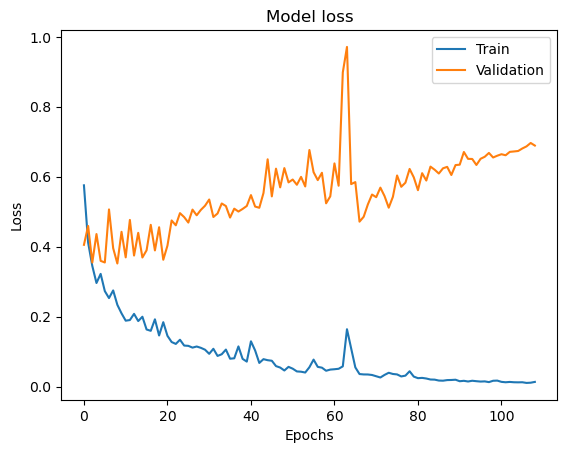

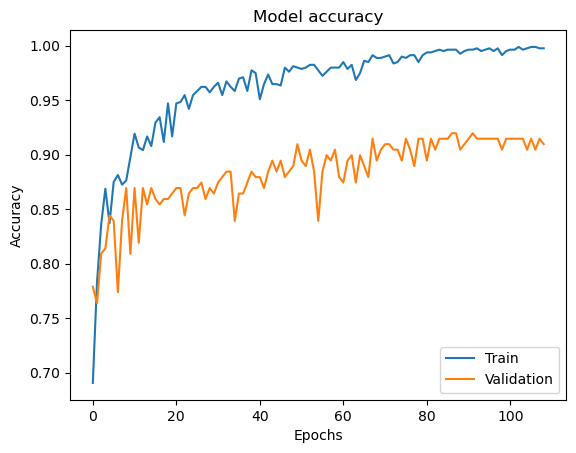

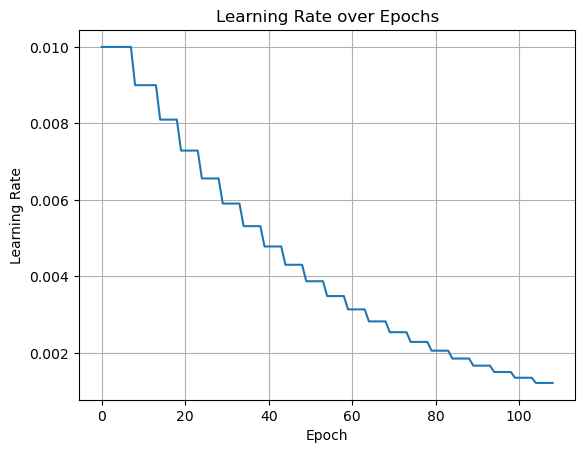

In [133]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plotting
# plt.figure(figsize=(8, 8))
plt.plot(lr_tracker.learning_rates)
plt.title("Learning Rate over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)

In [137]:
# Save the model
tf.keras.models.save_model(model, 'exo_model')

INFO:tensorflow:Assets written to: exo_model\assets


In [5]:
from tensorflow.keras.models import Model

model = tf.keras.models.load_model('exo_model')
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0 (Dense)              (None, 128)               8192      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_62 (Dense)             (None, 3)                 99        
Total params: 18,627
Trainable params: 18,627
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Assume 'original_model' is your pre-trained model
model_without_softmax = Model(inputs=model.input, 
                              outputs=model.get_layer("dense_2").output)
model_without_softmax.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0_input (InputLayer)   [(None, 63)]              0         
_________________________________________________________________
dense_0 (Dense)              (None, 128)               8192      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
Total params: 18,528
Trainable params: 18,528
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Save the model
tf.keras.models.save_model(model_without_softmax, 'exo_model_without_softmax')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: exo_model_without_softmax\assets


In [9]:
loaded_model = tf.keras.models.load_model('exo_model_without_softmax')
loaded_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0_input (InputLayer)   [(None, 63)]              0         
_________________________________________________________________
dense_0 (Dense)              (None, 128)               8192      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
Total params: 18,528
Trainable params: 18,528
Non-trainable params: 0
_________________________________________________________________
